# Первичная предобработка

In [ ]:
import pandas as pd
import numpy as np

from nltk import word_tokenize

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

import torchtext
import random

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
df = pd.read_csv('https://dl.uploadgram.me/6206a5de372cch?raw')
df.head(10)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


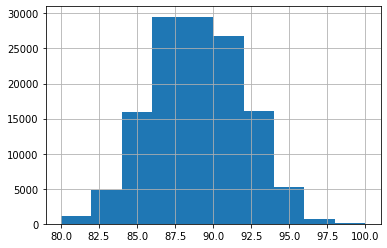

In [ ]:
df.points.hist()

In [ ]:
df = df[['description', 'points']]
df['points'] = df['points'].map(lambda x: 0 if x<88 else 1)

In [ ]:
df.head()

,description,points
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0


In [ ]:
df.points.value_counts()

1    78478
0    51493
Name: points, dtype: int64

In [ ]:
df.to_csv('/content/data.csv')

In [ ]:
del df

# Загрузка данных напрямую в torch

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
description = torchtext.legacy.data.Field(tokenize=word_tokenize, lower=True, batch_first=True)

In [ ]:
y = torchtext.legacy.data.Field(sequential=False, is_target=True, use_vocab=False)

In [ ]:
data = torchtext.legacy.data.TabularDataset(path='/content/data.csv', format='csv', 
                                     fields={
                                         'description': ('text', description),
                                         'points': ('points', y)
                                     })

w2v претрененный https://fasttext.cc/docs/en/english-vectors.html

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2022-02-11 18:11:47--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  45.8MB/s    in 16s     

2022-02-11 18:12:04 (40.4 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [ ]:
!unzip '/content/wiki-news-300d-1M.vec.zip' -d '/content/'

Archive:  /content/wiki-news-300d-1M.vec.zip
  inflating: /content/wiki-news-300d-1M.vec  


In [ ]:
description.build_vocab(data)

In [ ]:
description.vocab.load_vectors(torchtext.vocab.Vectors('/content/wiki-news-300d-1M.vec'))

100%|██████████| 999994/999994 [01:37<00:00, 10208.28it/s]


In [ ]:
description.vocab.vectors.shape

torch.Size([45955, 300])

In [ ]:
type(data)

torchtext.legacy.data.dataset.TabularDataset

In [ ]:
train, val = data.split(split_ratio= 0.8)

In [ ]:
len(train)

103977

In [ ]:
len(val)

25994

# Создание сети

In [ ]:
class lstm(nn.Module):
    def __init__(self, w2v, padding_inx, dropout, hidden_size):
        super(lstm, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(w2v)
        self.embedding.padding_inx = padding_inx

        self.embedding.weight.requires_grad = True

        self.dropout = nn.Dropout(p = dropout)
        self.lstm = nn.LSTM(input_size = self.embedding.embedding_dim,
                            hidden_size = hidden_size,
                            num_layers = 2,
                            dropout = dropout,
                            bidirectional = True)
        self.label = nn.Linear(hidden_size*2*2, 1)

    def forward(self, sentence):
        x = self.embedding(sentence)
        x = torch.transpose(x, dim0 = 1, dim1 = 0)
        out, (hidden, c) = self.lstm(x)
        x = self.dropout(torch.cat([c[i,:,:] for i in range(c.shape[0])], dim=1))
        x = self.label(x)
        return x

In [ ]:
batch_size = 64
train_i = torchtext.legacy.data.BucketIterator(dataset=train,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        sort = False,
                                        train =True)


val_i = torchtext.legacy.data.BucketIterator(dataset=val,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        sort = False,
                                        train = False)

In [ ]:
from torch import optim

In [ ]:
model = lstm(description.vocab.vectors, description.vocab.stoi[description.pad_token], dropout = 0.2, hidden_size=128).cuda()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
loss = nn.BCEWithLogitsLoss()

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Обучение сети

In [ ]:
def train(epochs, model, eval_time, loss_f, optimizer, train_i, val_i):
    step = 0

    losses = []
    val_losses = []

    accuracy = []
    val_accuracy = []

    train_i.init_epoch()
    for epoch in range(epochs):
        for batch in iter(train_i):
            step += 1
            model.train()
            x = batch.text.cuda()
            y = batch.points.type(torch.Tensor).cuda()

            model.zero_grad()
            preds = model.forward(x).view(-1)
            loss = loss_f(preds, y)
            losses.append(loss.cpu().data.numpy())
            accuracy.append(accuracy_score(batch.points.data.numpy().tolist(), 
                                           np.round(np.array( torch.sigmoid(preds).cpu().data.numpy().tolist()) )) 
            )
                                           

            loss.backward()
            optimizer.step()

            if step % eval_time == 0:
                clear_output(True)
                model.eval()
                model.zero_grad()
                # val_loss = []

                for batch in iter(val_i):
                    x = batch.text.cuda()
                    y = batch.points.type(torch.Tensor).cuda()

                    preds = model.forward(x).view(-1)
                    val_losses.append(loss_f(preds, y).cpu().data.numpy())
                
                    val_accuracy.append(accuracy_score(batch.points.data.numpy().tolist(), 
                                                   np.round(np.array( torch.sigmoid(preds).cpu().data.numpy().tolist() ))
                                                   ))


                fig, axs = plt.subplots(2, 2, figsize=(10, 10))
                fig.suptitle('Accuracy & Loss')
                
                axs[0, 0].set_title('train cross-entropy loss')
                axs[0, 1].set_title('test cross-entropy loss')
                axs[1, 0].set_title('train accuracy')
                axs[1, 1].set_title('test accuracy')

                axs[0, 0].plot(losses)
                axs[0, 0].plot(pd.Series(losses).rolling(400).mean().values)
                axs[0, 1].plot(val_losses)
                axs[0, 1].plot(pd.Series(val_losses).rolling(400).mean().values)
                axs[1, 0].plot(accuracy)
                axs[1, 0].plot(pd.Series(accuracy).rolling(400).mean().values)
                axs[1, 1].plot(val_accuracy)
                axs[1, 1].plot(pd.Series(val_accuracy).rolling(400).mean().values)
                
                

                for ax in axs.flat:
                    ax.set(xlabel='step')
                    # axs[0, 0].xaxis.set_ticks(np.arange(0, epochs, 1/len(losses)))
                plt.show()

                # print(f'Эпоха {epoch}, Шаг {step}, train_loss {np.array(losses).mean()}, valid_loss {np.array(val_loss).mean()}')
            

In [ ]:
%load_ext tensorboard
%tensorboard --logidir='./runs/'

In [ ]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [ ]:
model.to(device)

lstm(
  (embedding): Embedding(45955, 300)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2, bidirectional=True)
  (label): Linear(in_features=512, out_features=1, bias=True)
)

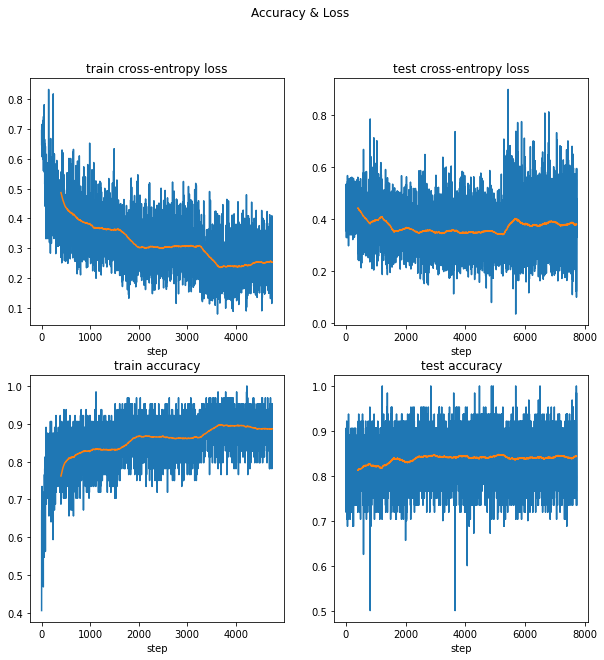

In [ ]:
# каждые 250 батчей обновляем график точностей и лоссов на train и test
train(3, model, 250, loss, optimizer, train_i, val_i)

In [ ]:
model.eval()

real = []
preds = []

for batch in iter(val_i):
    x = batch.text.cuda()
    # y = batch.points.type(torch.Tensor).cuda()
    
    real += batch.points.data.numpy().tolist()
    preds += torch.sigmoid(model.forward(x).view(-1)).cpu().data.numpy().tolist()

In [ ]:
print(classification_report(real, np.round(np.array(preds))))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80     10248
           1       0.87      0.88      0.87     15746

    accuracy                           0.84     25994
   macro avg       0.84      0.84      0.84     25994
weighted avg       0.84      0.84      0.84     25994

